## CoE 197M HW 2

#### Edward Vincent M. Duero
#### 2015-11198

In [1]:
import numpy as np

The mean $\mu$ and standard deviation $\sigma$ for generating the dataset $D$.

In [2]:
mean = 45
std = 3

Generate a 1,000,000 random samples from a Gaussian Distribution using the given $\mu$ and $\sigma$ binned into 1,000 histogram bins:

In [3]:
samples = 1000000
bin_size = 1000
rand_samples = np.random.normal(mean, 2*std, samples)
d_freq, bin_edges = np.histogram(rand_samples, bin_size)

Generate the dataset $D$. The dataset is a Python dictionary whose keys are the values from the Gaussian Distribution and the values are the probability. The probability for each value $f_{val}$ is determined as $\frac{f_{val}}{T_{total}}$ where  $T_{total}$ is the total number of samples (1,000,000)

In [4]:
D = dict(zip(bin_edges[0:1000], d_freq/samples))

Plotting the dataset $D$

In [5]:
import matplotlib.pyplot as plt

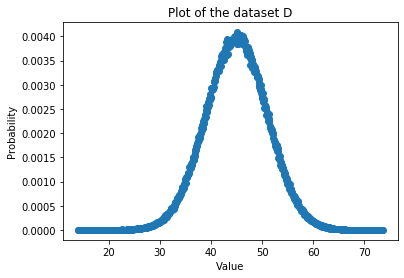

In [6]:
plt.plot(list(D.keys()), list(D.values()), 'o')
plt.xlabel("Value")
plt.ylabel("Probability")
plt.title("Plot of the dataset D")
plt.show()

Split $D$ randomly into two datasets: 90% for training (`D_train`) and 10% for testing (`D_test`). Both of these new datasets are also Python dictionaries whose keys are the value from the Gaussian Distribution and the values are the probability

In [7]:
import random

In [8]:
d_size_90 = int(d_freq.size * 0.9)
d_size_10 = int(d_freq.size * 0.1)

d_train_index = random.sample(list(bin_edges[0:1000]), d_size_90)
d_test_index = [item for item in list(bin_edges[0:1000]) if item not in set(d_train_index)]

D_train = dict(zip(d_train_index, [D[x] for x in d_train_index]))
D_test = dict(zip(d_test_index, [D[x] for x in d_test_index]))

## Creating a Neural Network
With the generation of the dataset done, the next step is to create the neural network from scratch. The neural network implemented in this homework is shown by the figure below:

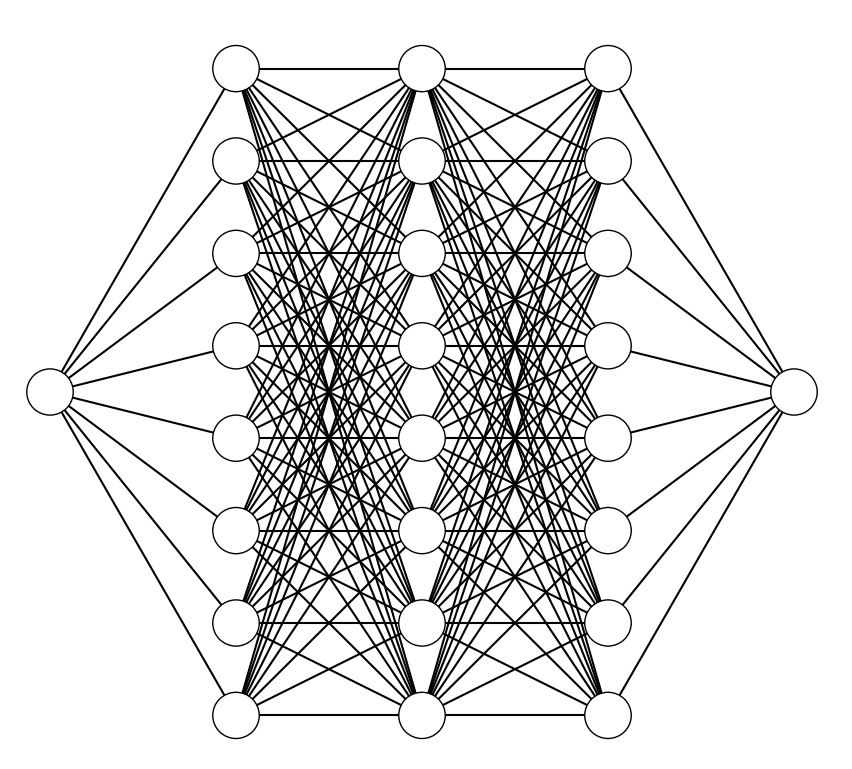

***NOTE***: In the implementation, the hidden layers have 64 neurons. But to have good-looking image representation, only 8 neurons were shown in the image.

From the image, the neural network has 3 hidden layers, the input layer, and the output layer. All the hidden layers have **64 neurons**. The first hidden layer has 1 input and 64 outputs with a ReLU activation function. The second hidden layer has 64 inputs and 64 outputs also with a ReLU activation function. The third hidden layer has 64 inputs and 1 output with no activation function. The output layer has a sigmoid activation function being applied to the result.

The first step in creating the neural network is to create the activation functions and other functions that will be used in the network. 

### Activation Functions
The activation functions that will be used are the *ReLU* and the *sigmoid* functions. The loss function that will be used is the Mean Squared Error (MSE). They are defined below:

In [9]:
def relu(x):
    return np.maximum(0, x)

def relu_dx(x):
    return np.select([x > 0, x < 0], [1, 0])

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_dx(x):
    return sigmoid(x)*(1.0 - sigmoid(x))

def mse(output, actual):
    return (np.square(np.subtract(output, actual)).mean())

### Creating a Neural Network Layer Class
In this part, a class for a layer of neurons is defined. The class named `LayerDense` has the function to calculate the forward propagation. The given inputs are the number of inputs to the hidden layer, the number of neurons of the layer, and the activation function that the layer will use.

In [10]:
class LayerDense:
    def __init__(self, n_inputs, n_neurons, activation_function):
#         np.random.seed(4)
        self.weights = np.random.normal(0, 0.01, (n_neurons, n_inputs))
        self.act_func = activation_function
        self.inputs = n_inputs
        
    def forward(self, x_input):
        self.z = np.dot(self.weights, x_input)
        return self.z
    
    def activate(self, z):
        if(self.act_func.lower() == "relu"):
            self.output = relu(z)
            return self.output
        elif(self.act_func.lower() == "sigmoid"):
            self.output = sigmoid(z)
            return self.output
        else:
            self.output = z
            return self.output
        

### Creating the Neural Network
The neural network that will be used is created as a class as shown below. The class can calculate both forward and back propagation. The neural network follows the specifications of the neural network described above.

In [11]:
class NeuralNetwork:
    def __init__(self):
        self.layer1 = LayerDense(1, 64, "ReLU")
        self.layer2 = LayerDense(64, 64, "ReLU")
        self.layer3 = LayerDense(64, 64, "")
        self.layer4 = LayerDense(64, 1, "sigmoid")
    
    def forwardpropagate(self, x_input):
        self.input = x_input
        
        self.z1 = self.layer1.forward(x_input)
        self.output1 = self.layer1.activate(self.z1)
        
        self.z2 = self.layer2.forward(self.output1)
        self.output2 = self.layer2.activate(self.z2)
        
        self.z3 = self.layer3.forward(self.output2)
        self.output3 = self.layer3.activate(self.z3)
        
        self.z4 = self.layer4.forward(self.output3)
        self.output4 = self.layer4.activate(self.z4)
        
        return self.output4
    
    def backpropagate(self, y_actual, learning_rate):
        self.error = mse(self.output4, y_actual)
        
        # backpropagate for Layer 4
        self.dl_da4 = (self.output4 - y_actual)
        self.da4_dz4 = sigmoid_dx(self.z4)
        self.dl_dz4 = np.multiply(self.dl_da4, self.da4_dz4)
        self.dl_dw4 = np.dot(self.dl_dz4, self.output3.T)
        
        # backpropagate for Layer 3
        self.dz4_da3 = self.layer4.weights.T
        self.da3_dz3 = 1
        self.dl_dz3 = np.multiply(np.dot(self.dz4_da3, self.dl_dz4), self.da3_dz3)
        self.dl_dw3 = np.dot(self.dl_dz3, self.output2.T)
        
        # backpropagate for Layer 2
        self.dz3_da2 = self.layer3.weights.T
        self.da2_dz2 = relu_dx(self.z2)
        self.dl_dz2 = np.multiply(np.dot(self.dz3_da2, self.dl_dz3), self.da2_dz2)
        self.dl_dw2 = np.dot(self.dl_dz2, self.output1.T)
        
        # backpropagate for Layer 1
        self.dz2_da1 = self.layer2.weights.T
        self.da1_dz1 = relu_dx(self.z1)
        self.dl_dz1 = np.multiply(np.dot(self.dz2_da1, self.dl_dz2), self.da1_dz1)
        self.dl_dw1 = np.dot(self.dl_dz1, self.input.T)
        
        # update layer weights
        self.layer1.weights -= learning_rate*self.dl_dw1
        self.layer2.weights -= learning_rate*self.dl_dw2
        self.layer3.weights -= learning_rate*self.dl_dw3
        self.layer3.weights -= learning_rate*self.dl_dw4     

### Training the developed Neural Network
Now that the neural network is created, the training is next. The dataset that will be used for training is `D_train` generated above. Random sampling will be performed, that is, the data from `D_train` that will be fed to the neural network is fed at random. This is done by using the `random.shuffle` function. The learning rate used is 0.1. 

In [12]:
learning_rate = 0.1

model = NeuralNetwork()

keys_train = list(D_train.keys())
random.shuffle(keys_train)

The errors for each epoch is printed along with the plot of the errors (MSE) as the training progresses.

|epoch:  1 	| loss:  0.01407625976351198 |
|epoch:  2 	| loss:  0.002625061246892914 |
|epoch:  3 	| loss:  0.001219017691707624 |
|epoch:  4 	| loss:  0.0007451431032038049 |
|epoch:  5 	| loss:  0.0005264900833309497 |
|epoch:  6 	| loss:  0.00040363441122341924 |
|epoch:  7 	| loss:  0.0003201921073835986 |
|epoch:  8 	| loss:  0.0002615657522807886 |
|epoch:  9 	| loss:  0.00021890451412147246 |
|epoch:  10 	| loss:  0.00018683261975026356 |
|epoch:  11 	| loss:  0.0001620354431423524 |
|epoch:  12 	| loss:  0.00014240209643527328 |
|epoch:  13 	| loss:  0.00012654154691047983 |
|epoch:  14 	| loss:  0.00011350748539088845 |
|epoch:  15 	| loss:  0.0001026375265145345 |
|epoch:  16 	| loss:  9.345619220749736e-05 |
|epoch:  17 	| loss:  8.561444401020928e-05 |
|epoch:  18 	| loss:  7.885103306672957e-05 |
|epoch:  19 	| loss:  7.296693091625018e-05 |
|epoch:  20 	| loss:  6.780814093117848e-05 |


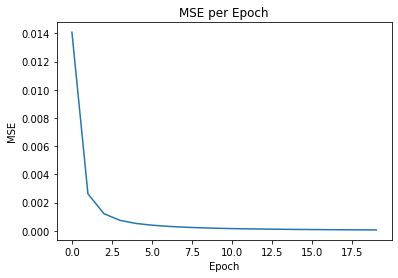

In [13]:
error_list = []
for epoch in range(20):
    for dic_keys in keys_train:
        predict = []
        actual = []
        
        x_input = dic_keys
        y = D_train[dic_keys]
        
        # Forward propagate
        prediction = model.forwardpropagate(x_input)
        
        predict.append(prediction)
        actual.append(y)
        
        # Backpropagate
        model.backpropagate(y, learning_rate)
    
    epoch_error = mse(predict, actual)
    print("|epoch: ", epoch+1, "\t| loss: ", epoch_error, "|")
    error_list.append(epoch_error)

plt.plot(error_list)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE per Epoch")
plt.show()

### Testing
After the training, testing will be performed. The trained neural network will be fed with new data that is part of the original dataset ***D***. The MSE of this test is also printed below.

In [14]:
for keys, vals in D_test.items():
    predict = []
    actual = []
    
    x = keys
    y = vals
    
    prediction = model.forwardpropagate(x)
    
    predict.append(prediction)
    actual.append(y)

print("Test MSE: ", mse(predict, actual))

Test MSE:  1.1068178162107737e-17
